In [1]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import aquarel as aq
from ineqpy.inequality import gini
import scipy.stats as st
import pyalex as alex
alex.config.email = "noah0roussel01980@gmail.com"
works = pl.read_csv("../../../data/works/works_q1.csv")
works = works.filter(pl.col("year") != 2025)

year_begin = 1920
year_end = 2024
works = works.with_columns(
    age=2025 - pl.col("year")
)

In [2]:
cbc_per_year = (
    works
    .select(
        [pl.col("year"), pl.col("cited_by_count"), pl.col("title")]
    )
    .group_by(
        pl.col("year"),
        maintain_order=True
    )
    .agg(
        pl.col("cited_by_count").mean().name.prefix("mean_")
    )
) # number of citations (cbc = cited by count) of the works published a given year

works = works.join(
    cbc_per_year,
    on="year",
    how="left"
) # left join

works = (
    works
    .with_columns(
        mncs = pl.col("cited_by_count") / pl.col("mean_cited_by_count")
    )
    .drop("mean_cited_by_count")
)
cols_authors = [col for col in works.columns if col.startswith("author_")]

works = works.with_columns(
    authors_count = sum(
        [pl.col(col).is_not_null().cast(pl.Int8) for col in cols_authors]
    )

)

works = works.with_columns(
    title = pl.col("title").fill_null("").str.to_lowercase(),
    abstract = pl.col("abstract").fill_null("").str.to_lowercase()
)

works = works.with_columns(
    review = (
        pl.col("title").str.contains("review") |
        pl.col("abstract").str.contains("review")
    ),
    meta_analysis = (
        pl.col("title").str.contains("meta[\u00AD-]?analysis") |
        pl.col("abstract").str.contains("meta[\u00AD-]?analysis")
    )
)

works = works.with_columns([
    pl.when(pl.col("countries_distinct_count").is_null() | pl.col("countries_distinct_count").is_nan() | (pl.col("countries_distinct_count") == 0))
      .then(1)
      .otherwise(pl.col("countries_distinct_count"))
      .alias("countries_distinct_count")
])
works = works.with_columns([
    pl.when(pl.col("institutions_distinct_count").is_null() | pl.col("institutions_distinct_count").is_nan() | (pl.col("institutions_distinct_count") == 0))
      .then(1)
      .otherwise(pl.col("institutions_distinct_count"))
      .alias("institutions_distinct_count")
])

works

shape: (689_361, 1_080)
┌─────────────┬──────┬─────────────┬────────────┬───┬───────────┬────────────┬────────┬────────────┐
│ title       ┆ year ┆ cited_by_co ┆ countries_ ┆ … ┆ mncs      ┆ authors_co ┆ review ┆ meta_analy │
│ ---         ┆ ---  ┆ unt         ┆ distinct_c ┆   ┆ ---       ┆ unt        ┆ ---    ┆ sis        │
│ str         ┆ i64  ┆ ---         ┆ ount       ┆   ┆ f64       ┆ ---        ┆ bool   ┆ ---        │
│             ┆      ┆ i64         ┆ ---        ┆   ┆           ┆ i8         ┆        ┆ bool       │
│             ┆      ┆             ┆ i64        ┆   ┆           ┆            ┆        ┆            │
╞═════════════╪══════╪═════════════╪════════════╪═══╪═══════════╪════════════╪════════╪════════════╡
│ ros stress  ┆ 2004 ┆ 1881        ┆ 1          ┆ … ┆ 35.103559 ┆ 3          ┆ false  ┆ false      │
│ in cancer   ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ cells and…  ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ aminoglycos ┆ 2010 ┆ 1294        ┆ 1          ┆ … ┆ 24.857588 ┆ 2          ┆ false  ┆ false      │
│ ide         ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ modifying   ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ enzym…      ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ overcoming  ┆ 2015 ┆ 898         ┆ 2          ┆ … ┆ 23.127161 ┆ 6          ┆ false  ┆ false      │
│ the         ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ blood–brain ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ tum…        ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ targeting   ┆ 2008 ┆ 786         ┆ 1          ┆ … ┆ 14.902469 ┆ 4          ┆ false  ┆ false      │
│ the pi3k/ak ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ t/mtor pa…  ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ if not      ┆ 2001 ┆ 722         ┆ 1          ┆ … ┆ 12.263251 ┆ 3          ┆ false  ┆ false      │
│ apoptosis,  ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ then what?  ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ t…          ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ …           ┆ …    ┆ …           ┆ …          ┆ … ┆ …         ┆ …          ┆ …      ┆ …          │
│ contributor ┆ 1992 ┆ 0           ┆ 1          ┆ … ┆ 0.0       ┆ 0          ┆ false  ┆ false      │
│ s           ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ copyright   ┆ 1992 ┆ 0           ┆ 1          ┆ … ┆ 0.0       ┆ 0          ┆ false  ┆ false      │
│ preface     ┆ 1992 ┆ 0           ┆ 1          ┆ … ┆ 0.0       ┆ 1          ┆ false  ┆ false      │
│ dendritic   ┆ 1991 ┆ 0           ┆ 1          ┆ … ┆ 0.0       ┆ 1          ┆ false  ┆ false      │
│ cells in    ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ the         ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ inducti…    ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ protein con ┆ 1991 ┆ 0           ┆ 1          ┆ … ┆ 0.0       ┆ 6          ┆ false  ┆ false      │
│ formation   ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ affects t…  ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
└─────────────┴──────┴─────────────┴────────────┴───┴───────────┴────────────┴────────┴────────────┘

In [3]:
works = works.with_columns(
    primary_topic = pl.col("primary_topic").str.replace("'","", literal=True, n=2).str.replace("(","", literal=True).str.replace(")","", literal=True).str.replace(",","", literal=True),
    primary_subfield = pl.col("primary_subfield").str.replace("'","", literal=True, n=2).str.replace("(","", literal=True).str.replace(")","", literal=True).str.replace(",","", literal=True),
    primary_field = pl.col("primary_field").str.replace("'","", literal=True, n=2).str.replace("(","", literal=True).str.replace(")","", literal=True).str.replace(",","", literal=True), 
    primary_domain = pl.col("primary_domain").str.replace("'","", literal=True, n=2).str.replace("(","", literal=True).str.replace(")","", literal=True).str.replace(",","", literal=True)
)
works

shape: (689_361, 1_080)
┌─────────────┬──────┬─────────────┬────────────┬───┬───────────┬────────────┬────────┬────────────┐
│ title       ┆ year ┆ cited_by_co ┆ countries_ ┆ … ┆ mncs      ┆ authors_co ┆ review ┆ meta_analy │
│ ---         ┆ ---  ┆ unt         ┆ distinct_c ┆   ┆ ---       ┆ unt        ┆ ---    ┆ sis        │
│ str         ┆ i64  ┆ ---         ┆ ount       ┆   ┆ f64       ┆ ---        ┆ bool   ┆ ---        │
│             ┆      ┆ i64         ┆ ---        ┆   ┆           ┆ i8         ┆        ┆ bool       │
│             ┆      ┆             ┆ i64        ┆   ┆           ┆            ┆        ┆            │
╞═════════════╪══════╪═════════════╪════════════╪═══╪═══════════╪════════════╪════════╪════════════╡
│ ros stress  ┆ 2004 ┆ 1881        ┆ 1          ┆ … ┆ 35.103559 ┆ 3          ┆ false  ┆ false      │
│ in cancer   ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ cells and…  ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ aminoglycos ┆ 2010 ┆ 1294        ┆ 1          ┆ … ┆ 24.857588 ┆ 2          ┆ false  ┆ false      │
│ ide         ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ modifying   ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ enzym…      ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ overcoming  ┆ 2015 ┆ 898         ┆ 2          ┆ … ┆ 23.127161 ┆ 6          ┆ false  ┆ false      │
│ the         ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ blood–brain ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ tum…        ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ targeting   ┆ 2008 ┆ 786         ┆ 1          ┆ … ┆ 14.902469 ┆ 4          ┆ false  ┆ false      │
│ the pi3k/ak ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ t/mtor pa…  ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ if not      ┆ 2001 ┆ 722         ┆ 1          ┆ … ┆ 12.263251 ┆ 3          ┆ false  ┆ false      │
│ apoptosis,  ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ then what?  ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ t…          ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ …           ┆ …    ┆ …           ┆ …          ┆ … ┆ …         ┆ …          ┆ …      ┆ …          │
│ contributor ┆ 1992 ┆ 0           ┆ 1          ┆ … ┆ 0.0       ┆ 0          ┆ false  ┆ false      │
│ s           ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ copyright   ┆ 1992 ┆ 0           ┆ 1          ┆ … ┆ 0.0       ┆ 0          ┆ false  ┆ false      │
│ preface     ┆ 1992 ┆ 0           ┆ 1          ┆ … ┆ 0.0       ┆ 1          ┆ false  ┆ false      │
│ dendritic   ┆ 1991 ┆ 0           ┆ 1          ┆ … ┆ 0.0       ┆ 1          ┆ false  ┆ false      │
│ cells in    ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ the         ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ inducti…    ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ protein con ┆ 1991 ┆ 0           ┆ 1          ┆ … ┆ 0.0       ┆ 6          ┆ false  ┆ false      │
│ formation   ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ affects t…  ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
└─────────────┴──────┴─────────────┴────────────┴───┴───────────┴────────────┴────────┴────────────┘

In [4]:
group_topics = (
    works
    .group_by("primary_topic")
    .agg([
        pl.count().alias("count"),  # nombre de publications
        pl.sum("cited_by_count").alias("cited_by_count")  # total des citations
    ])
    .sort("cited_by_count", descending=True)
)

C:\Users\noahr\AppData\Local\Temp\ipykernel_22688\2584677564.py:5: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("count"),  # nombre de publications


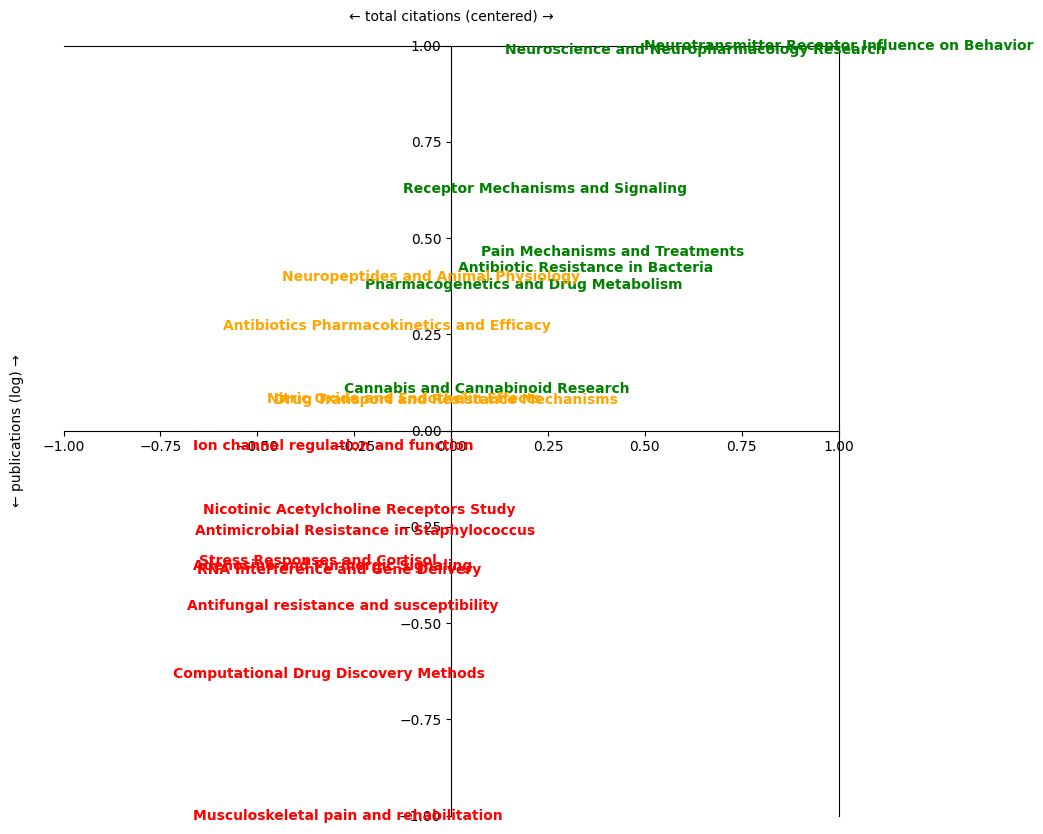

In [5]:
# --- 2️⃣ Garder le top 10 ---
top_10_topics = group_topics.head(20)

# --- 3️⃣ Préparer les coordonnées pour le plot ---
top_10_topics = top_10_topics.with_columns([
    pl.col("count").log().alias("publications_log")  # log du nombre de publications
])

mean_cit = top_10_topics["cited_by_count"].mean()
top_10_topics = top_10_topics.with_columns(
    (pl.col("cited_by_count") - mean_cit).alias("citations_centered")
)

# extraire les colonnes en tant que Series, puis en numpy
pub_log = top_10_topics["publications_log"].to_numpy()
y_min = np.min(pub_log)
y_max = np.max(pub_log)

citations = top_10_topics["cited_by_count"].to_numpy()
cit_mean = np.mean(citations)
cit_max_abs = np.max(np.abs(citations - cit_mean))

top_10_topics = top_10_topics.with_columns([
    ((pl.col("publications_log") - y_min) / (y_max - y_min) * 2 - 1).alias("y_viz"),
    ((pl.col("cited_by_count") - cit_mean) / cit_max_abs).alias("x_viz")
])

# --- 4️⃣ Plot ---
plt.figure(figsize=(10, 10))

for name, x, y in zip(
    top_10_topics["primary_topic"],
    top_10_topics["x_viz"],
    top_10_topics["y_viz"]
):
    if y >= 0 and x >= 0:
        color = "green"
    elif y >= 0 and x < 0:
        color = "orange"
    elif y < 0 and x < 0:
        color = "red"
    else:
        color = "purple"
    plt.text(x, y, name, ha="center", va="center", fontsize=10, fontweight="bold", color=color)


plt.xlabel("← total citations (centered) →", labelpad=-320)
plt.ylabel("← publications (log) →", labelpad=270)
plt.xlim(-1, 1)
plt.ylim(-1, 1)

ax = plt.gca()
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')

plt.show()

C:\Users\noahr\AppData\Local\Temp\ipykernel_22688\1503608326.py:15: DeprecationWarning: the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.
  topics_pivot = covid.pivot(


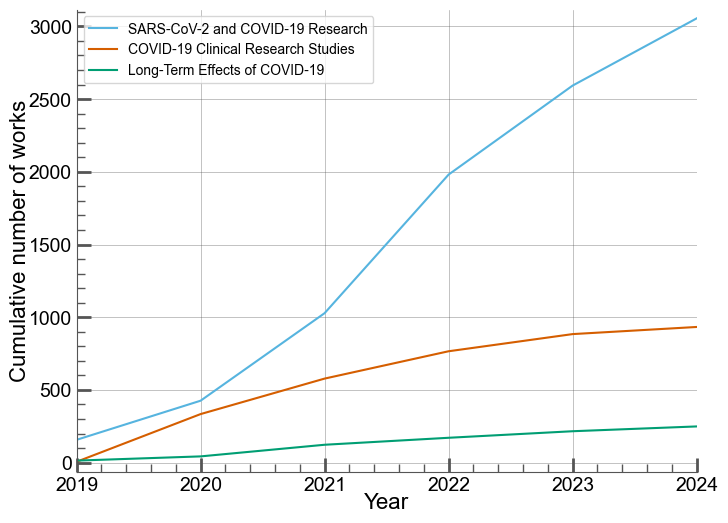

In [6]:
covid = (
    works
    .select(["primary_topic", "year", "title"])
    .filter(
        pl.col("primary_topic").is_in([
            "COVID-19 Clinical Research Studies",
            "SARS-CoV-2 and COVID-19 Research",
            "Long-Term Effects of COVID-19"
        ])
    )
    .group_by(["primary_topic", "year"])
    .agg(pl.count("title").alias("count"))
)

topics_pivot = covid.pivot(
    values="count",
    index="year",
    columns="primary_topic"
).sort("year")

topics_pivot = topics_pivot.fill_null(0)

for col in topics_pivot.columns[1:]:  
    topics_pivot = topics_pivot.with_columns(
        pl.col(col).cum_sum().alias(col)
    )

years = topics_pivot["year"].to_list()
with aq.load_theme("scientific"):
    plt.figure(figsize=(8, 6))
    for col in topics_pivot.columns[1:]:
        plt.plot(years, topics_pivot[col].to_list(), label=col)
    plt.xlabel("Year", fontsize=16)
    plt.ylabel("Cumulative number of works", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlim(2019, 2024)
    plt.legend()
    plt.show()


<Figure size 640x480 with 0 Axes>

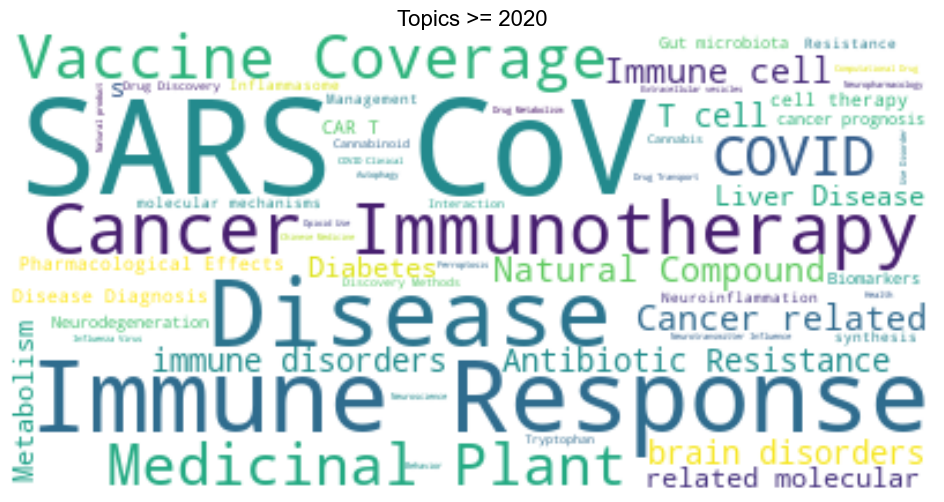

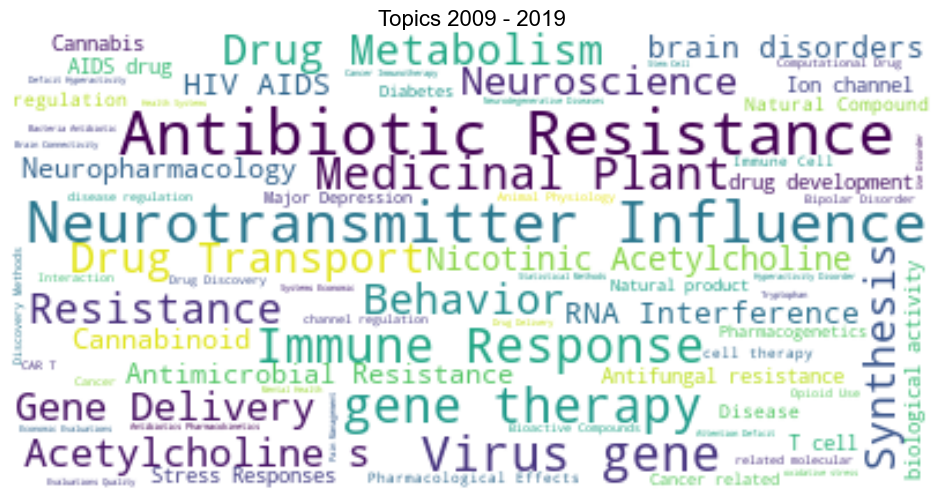

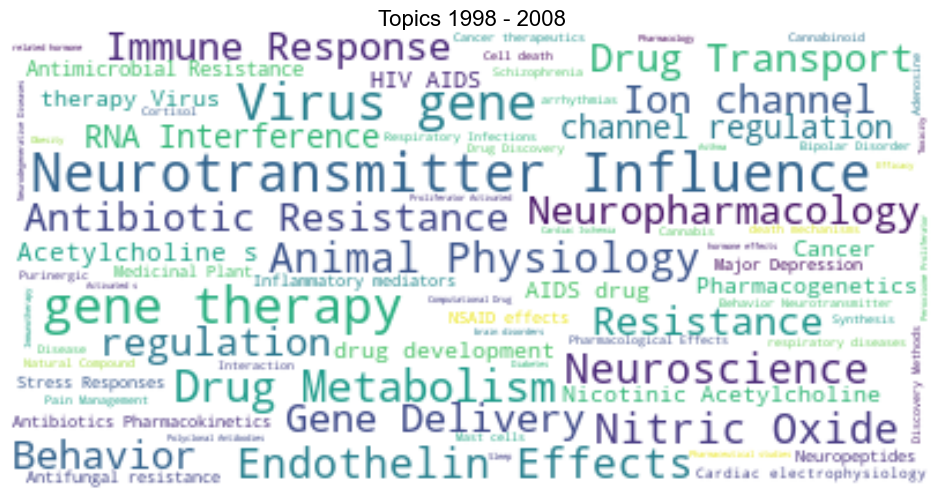

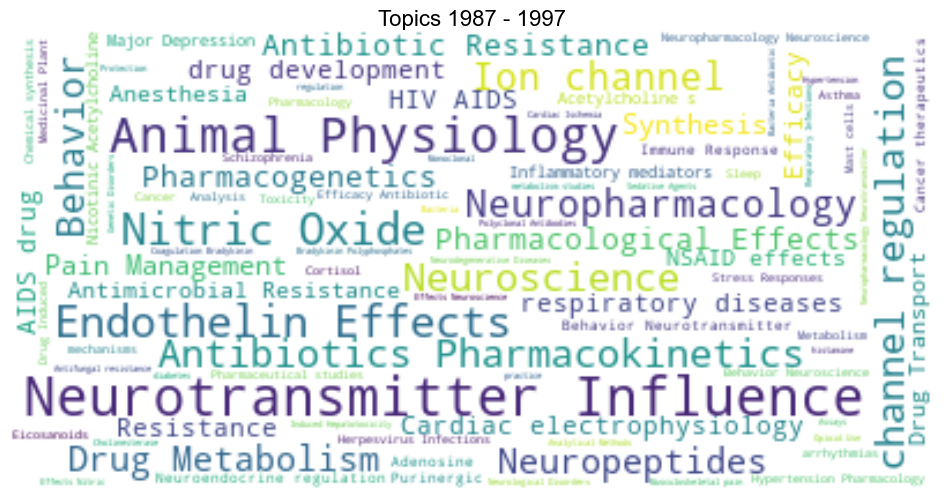

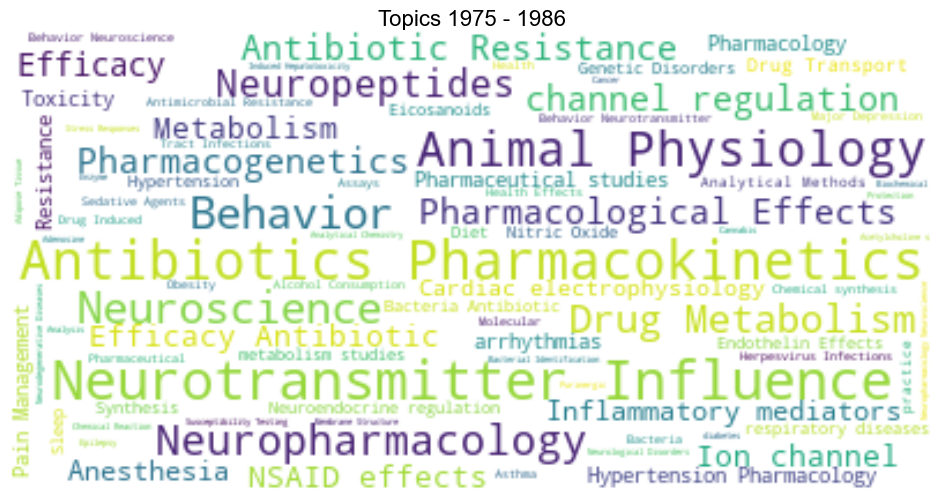

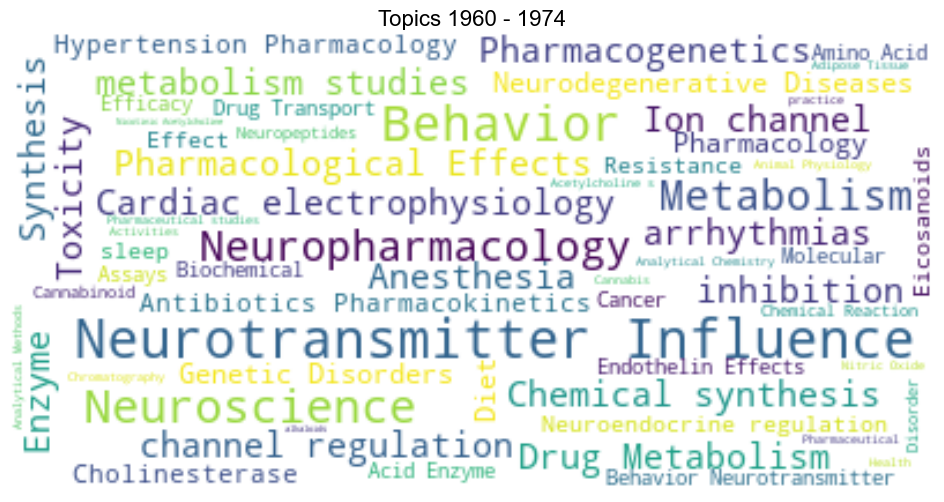

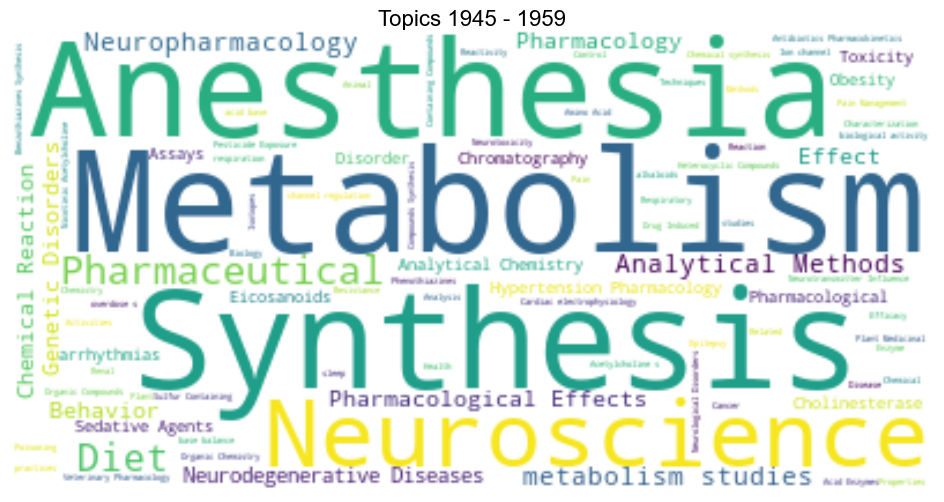

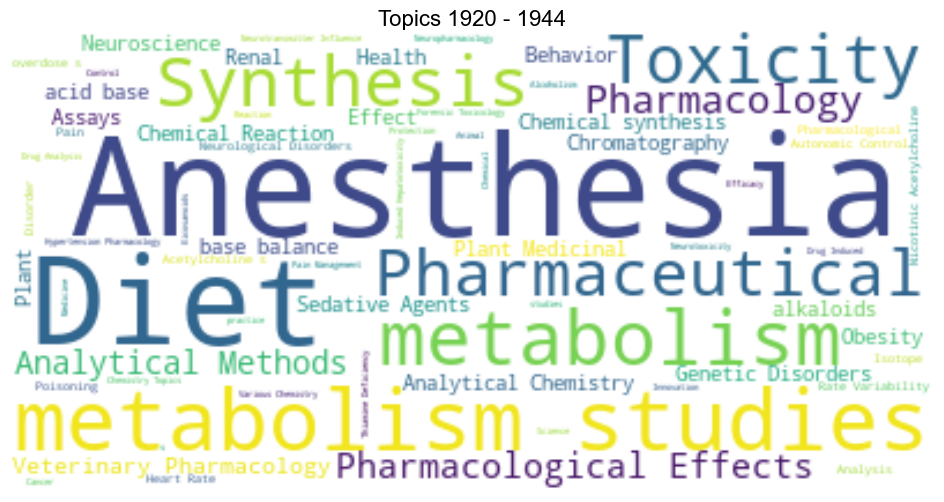

In [7]:
import wordcloud as wc

year_ranges = [
    (">= 2020", pl.col("year") >= 2020),
    ("2009 - 2019", (pl.col("year") >= 2009) & (pl.col("year") < 2020)),
    ("1998 - 2008", (pl.col("year") >= 1998) & (pl.col("year") < 2009)),
    ("1987 - 1997", (pl.col("year") >= 1987) & (pl.col("year") < 1998)),
    ("1975 - 1986", (pl.col("year") >= 1975) & (pl.col("year") < 1987)),
    ("1960 - 1974", (pl.col("year") >= 1960) & (pl.col("year") < 1975)),
    ("1945 - 1959", (pl.col("year") >= 1945) & (pl.col("year") < 1960)),
    ("1920 - 1944", (pl.col("year") >= 1920) & (pl.col("year") < 1945)),
]



stopwords_custom = ["Research", "Treatment", "Signaling", "Applications", 
                    "Mechanisms", "research", " s ", "Receptor", 
                    "function", "Studies","treatment","based","Study"]

for label, condition in year_ranges:
    works_new = works.filter(condition)

    primary_topics = (
        works_new
        .filter(pl.col("primary_topic").is_not_null())
        .select("primary_topic")
        .to_series()
        .to_list()
    )

    text = " ".join(primary_topics)
    for word in stopwords_custom:
        text = text.replace(word, "")


    wordcloud = wc.WordCloud(background_color="white").generate(text)

    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(f"Topics {label}", fontsize=16)
    plt.axis("off")
    plt.show()


In [34]:
import os
output_dir = "../../../data/vosviewer"


for label, condition in year_ranges:
    works_period = works.filter(condition).filter(pl.col("primary_topic").is_not_null())

    # Extraire les topics et nettoyer les stopwords
    primary_topics = works_period.select("primary_topic").to_series().to_list()
    cleaned_topics = []
    for topic in primary_topics:
        topic_clean = str(topic)
        for word in stopwords_custom:
            topic_clean = topic_clean.replace(word, "")
        topic_clean = topic_clean.strip()  # enlever espaces en trop
        if topic_clean:  # ignorer les lignes vides
            cleaned_topics.append(topic_clean)

    if not cleaned_topics:
        print(f"Aucune donnée après nettoyage pour {label}, fichier ignoré.")
        continue

    # Préparer le DataFrame Polars avec la colonne 'Title'
    df_cleaned = pl.DataFrame({"Title": cleaned_topics})

    # Nom de fichier sûr
    safe_label = label.replace(" ", "").replace(">=", "_sup")
    output_path = os.path.join(output_dir, f"topics{safe_label}.csv")

    df_cleaned.write_csv(output_path)

    print(f"✅ File created : {output_path} ({len(cleaned_topics)} lines)")


✅ File created : ../../../data/vosviewer\topics_sup2020.csv (131692 lines)
✅ File created : ../../../data/vosviewer\topics2009-2019.csv (203513 lines)
✅ File created : ../../../data/vosviewer\topics1998-2008.csv (147512 lines)
✅ File created : ../../../data/vosviewer\topics1987-1997.csv (96145 lines)
✅ File created : ../../../data/vosviewer\topics1975-1986.csv (54151 lines)
✅ File created : ../../../data/vosviewer\topics1960-1974.csv (18750 lines)
✅ File created : ../../../data/vosviewer\topics1945-1959.csv (2873 lines)
✅ File created : ../../../data/vosviewer\topics1920-1944.csv (2722 lines)


In [35]:
import bar_chart_race as bcr


topics_pivot = (
    works
    .group_by(["primary_topic", "year"], maintain_order=True)
    .agg([
        pl.count("title").alias("n")  
    ])
    .filter(pl.col("primary_topic").is_not_null())  
    .pivot(index="year", columns="primary_topic", values="n")
    .fill_null(0)
    .sort("year")
)

topics_pivot_pd = topics_pivot.to_pandas().set_index("year")

topics_pivot_pd = topics_pivot_pd.cumsum()


topics_pivot_pd.index = pd.PeriodIndex(topics_pivot_pd.index, freq="Y").to_timestamp()


bcr.bar_chart_race(
    df=topics_pivot_pd,
    filename='q1_topics_over_time.mp4',  
    orientation='h',
    sort='desc',
    n_bars=10,
    fixed_order=False,
    fixed_max=True,
    steps_per_period=8,
    period_length=800,
    period_fmt='%Y',
    title='Evolution of the Top Topics Over Time',
    bar_size=.95,
    interpolate_period=True
)


C:\Users\noahr\AppData\Local\Temp\ipykernel_22688\1767371447.py:11: DeprecationWarning: the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.
  .pivot(index="year", columns="primary_topic", values="n")
Locator attempting to generate 15996 ticks ([-62.0, ..., 3137.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 15996 ticks ([-62.0, ..., 3137.0]), which exceeds Locator.MAXTICKS (1000).
C:\Users\noahr\AppData\Roaming\Python\Python312\site-packages\bar_chart_race\_make_chart.py:284: UserWarning: Glyph 127 () missing from font(s) Arial.
  fig.canvas.print_figure(io.BytesIO())
C:\Users\noahr\AppData\Roaming\Python\Python312\site-packages\bar_chart_race\_make_chart.py:284: UserWarning: Glyph 128 (\x80) missing from font(s) Arial.
  fig.canvas.print_figure(io.BytesIO())
C:\Users\noahr\AppData\Roaming\Python\Python312\site-packages\bar_chart_race\_make_chart.py:284: UserWarning: Glyph 129 (\x81) missing from font(s) Aria

In [36]:
smoothing = 5
start_year = 1920

topics_pivot = (
    works
    .group_by(["primary_topic", "year"], maintain_order=True)
    .agg([pl.count("title").alias("n")])  
    .filter(pl.col("primary_topic").is_not_null())  
    .pivot(index="year", columns="primary_topic", values="n")
    .fill_null(0)
    .sort("year")
)


topics_pivot_pd = topics_pivot.to_pandas().set_index("year")
topics_pivot_pd_smooth = topics_pivot_pd.copy()

for index in topics_pivot_pd.index:
    debut = max(start_year, index - smoothing)
    years_range = [y for y in range(debut, index+1) if y in topics_pivot_pd.index]
    topics_pivot_pd_smooth.loc[index, :] = topics_pivot_pd.loc[years_range, :].sum()

topics_pivot_pd_smooth.index = pd.PeriodIndex(topics_pivot_pd_smooth.index, freq="Y").to_timestamp()


bcr.bar_chart_race(
    df=topics_pivot_pd_smooth,
    filename='q1_topics_over_time_5ysmooth.mp4',
    writer='ffmpeg',
    orientation='h',
    sort='desc',
    n_bars=10,
    fixed_order=False,
    fixed_max=True,
    steps_per_period=8,
    period_length=800,
    period_fmt='%Y',
    title='Evolution of the top topics along the years (5-year period)',
    bar_size=.95,
    interpolate_period=True
)

C:\Users\noahr\AppData\Local\Temp\ipykernel_22688\3497396542.py:9: DeprecationWarning: the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.
  .pivot(index="year", columns="primary_topic", values="n")
Locator attempting to generate 15996 ticks ([-62.0, ..., 3137.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 15996 ticks ([-62.0, ..., 3137.0]), which exceeds Locator.MAXTICKS (1000).
C:\Users\noahr\AppData\Roaming\Python\Python312\site-packages\bar_chart_race\_make_chart.py:284: UserWarning: Glyph 127 () missing from font(s) Arial.
  fig.canvas.print_figure(io.BytesIO())
C:\Users\noahr\AppData\Roaming\Python\Python312\site-packages\bar_chart_race\_make_chart.py:284: UserWarning: Glyph 128 (\x80) missing from font(s) Arial.
  fig.canvas.print_figure(io.BytesIO())
C:\Users\noahr\AppData\Roaming\Python\Python312\site-packages\bar_chart_race\_make_chart.py:284: UserWarning: Glyph 129 (\x81) missing from font(s) Arial

In [37]:

selected_topics = [
    "Neurotransmitter Receptor Influence on Behavior",
    "Neuroscience and Neuropharmacology Research",
    "Receptor Mechanisms and Signaling",
    "Pain Mechanisms and Treatments",
]

works_filtered = works.filter(
    (pl.col("primary_topic").is_in(selected_topics)) &
    (pl.col("primary_topic").is_not_null()) &
    (pl.col("year") >= start_year)
)
topics_pivot = (
    works_filtered
    .group_by(["primary_topic", "year"])
    .agg(pl.count("title").alias("count"))
    .pivot(index="year", columns="primary_topic", values="count")
    .fill_null(0)
    .sort("year")
)

topics_pivot = topics_pivot.with_columns([
    pl.col(col).cum_sum().alias(col) for col in selected_topics if col in topics_pivot.columns
])

topics_pivot


C:\Users\noahr\AppData\Local\Temp\ipykernel_22688\3069548654.py:17: DeprecationWarning: the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.
  .pivot(index="year", columns="primary_topic", values="count")


shape: (104, 5)
┌──────┬─────────────────────────┬─────────────────────┬──────────────────┬──────────────────┐
│ year ┆ Receptor Mechanisms and ┆ Pain Mechanisms and ┆ Neuroscience and ┆ Neurotransmitter │
│ ---  ┆ Signal…                 ┆ Treatments          ┆ Neuropharmaco…   ┆ Receptor Infl…   │
│ i64  ┆ ---                     ┆ ---                 ┆ ---              ┆ ---              │
│      ┆ u32                     ┆ u32                 ┆ u32              ┆ u32              │
╞══════╪═════════════════════════╪═════════════════════╪══════════════════╪══════════════════╡
│ 1920 ┆ 0                       ┆ 1                   ┆ 0                ┆ 1                │
│ 1921 ┆ 1                       ┆ 2                   ┆ 0                ┆ 1                │
│ 1923 ┆ 1                       ┆ 2                   ┆ 1                ┆ 1                │
│ 1924 ┆ 1                       ┆ 2                   ┆ 2                ┆ 2                │
│ 1925 ┆ 2                       ┆ 2                   ┆ 3                ┆ 2                │
│ …    ┆ …                       ┆ …                   ┆ …                ┆ …                │
│ 2020 ┆ 10895                   ┆ 9000                ┆ 16044            ┆ 16355            │
│ 2021 ┆ 11075                   ┆ 9214                ┆ 16296            ┆ 16561            │
│ 2022 ┆ 11204                   ┆ 9406                ┆ 16479            ┆ 16724            │
│ 2023 ┆ 11407                   ┆ 9587                ┆ 16656            ┆ 16894            │
│ 2024 ┆ 11592                   ┆ 9810                ┆ 16848            ┆ 17048            │
└──────┴─────────────────────────┴─────────────────────┴──────────────────┴──────────────────┘

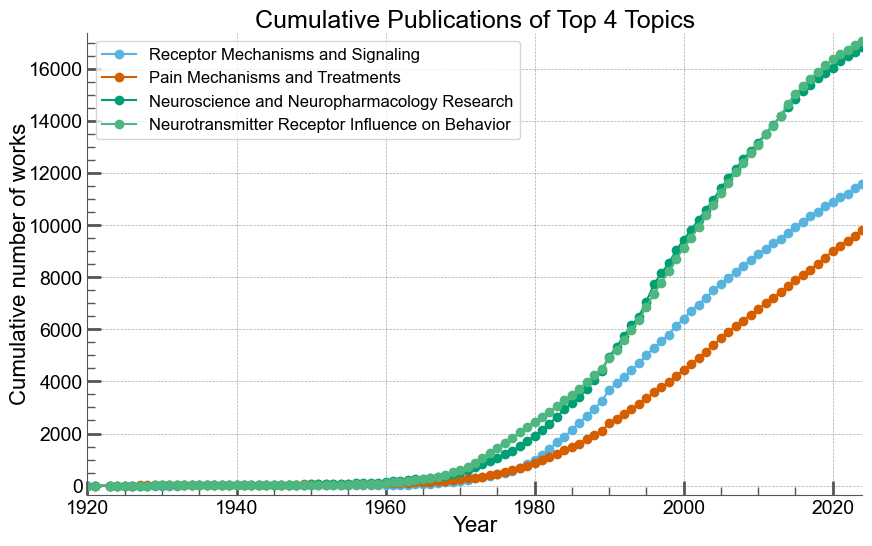

In [38]:
years = topics_pivot["year"].to_list()

with aq.load_theme("scientific"):
    plt.figure(figsize=(10, 6))
    
    # Boucle sur les colonnes (les topics)
    for col in topics_pivot.columns:
        if col != "year":  # ignorer la colonne year
            plt.plot(years, topics_pivot[col].to_list(), label=col, marker='o')
    
    plt.xlabel("Year", fontsize=16)
    plt.ylabel("Cumulative number of works", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlim(min(years), max(years))  # ou remplacer par 2019, 2024 si tu veux zoomer
    plt.legend(fontsize=12)
    plt.title("Cumulative Publications of Top 4 Topics", fontsize=18)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

In [39]:
group_subfields_bis = (
    works
    .drop_nulls(subset=["primary_subfield"])
    .select(["primary_subfield", "year", "title"])
    .group_by(["primary_subfield", "year"])
    .agg(pl.count("title").alias("count"))
)

subfields_pivot = (
    group_subfields_bis
    .pivot(
        values="count",
        index="year",
        columns="primary_subfield"
    )
    .sort("year")
    .fill_null(0)
)

subfields_pivot = subfields_pivot.select(
    ["year"] + [
        pl.col(col).cum_sum().alias(col) 
        for col in subfields_pivot.columns if col != "year"
    ]
)

subfields_pivot_pd = subfields_pivot.to_pandas()
subfields_pivot_pd.index = pd.to_datetime(subfields_pivot_pd["year"], format="%Y")
subfields_pivot_pd = subfields_pivot_pd.drop(columns="year")

bcr.bar_chart_race(
    df=subfields_pivot_pd,
    filename='q1_subfields_over_time.mp4', 
    orientation='h',
    sort='desc',
    n_bars=5,
    fixed_order=False,
    fixed_max=True,
    steps_per_period=10,
    period_length=1000,
    period_fmt='%Y',
    title='Evolution of the top subfields along the years',
    bar_size=.95,
    interpolate_period=True
)

C:\Users\noahr\AppData\Local\Temp\ipykernel_22688\3284848325.py:11: DeprecationWarning: the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.
  .pivot(
Locator attempting to generate 1221 ticks ([-5.0, ..., 239.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1221 ticks ([-5.0, ..., 239.0]), which exceeds Locator.MAXTICKS (1000).
C:\Users\noahr\AppData\Roaming\Python\Python312\site-packages\bar_chart_race\_make_chart.py:284: UserWarning: Glyph 127 () missing from font(s) Arial.
  fig.canvas.print_figure(io.BytesIO())
C:\Users\noahr\AppData\Roaming\Python\Python312\site-packages\bar_chart_race\_make_chart.py:284: UserWarning: Glyph 128 (\x80) missing from font(s) Arial.
  fig.canvas.print_figure(io.BytesIO())
C:\Users\noahr\AppData\Roaming\Python\Python312\site-packages\bar_chart_race\_make_chart.py:284: UserWarning: Glyph 129 (\x81) missing from font(s) Arial.
  fig.canvas.print_figure(io.BytesIO())
C:\Users\noah